# DMT Share - News Classification with Neural Network

Notebook for NLP Implementation on building classification model to predict news category from its headline or title. This is our R&D project for DMT Share.

<br>

**Author**
- **Rio Julian Azis** - DMT Data Science and Analytics
- **Leonardi Fabianto** - DMT Data Engineer

<br>

**Data Source**

[**Kompas.com**](https://www.kompas.com/) and [**CNN Indonesia**](https://www.cnnindonesia.com/) news website, collected with web-scraping. Data is imported by calling scraper API. For more info about web-scraper and API code, check [source code repository](https://github.com/avidito/dmt-share-ws-nlp).

<br>

**Notable Libraries**

Below are the list of notable libraries that used on this project:
- [NLTK](https://www.nltk.org/)
- [Sastrawi](https://github.com/sastrawi/sastrawi)
- [Keras - Tensorflow](https://www.tensorflow.org/)
- [scikit-learn](https://scikit-learn.org/stable/)

## Data Extraction

In [1]:
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

### Retrieve Data from GDrive

In [2]:
# Mounting GDrive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# data = pd.read_csv('/content/drive/MyDrive/DMT Share/scraping_result.csv')
# stopwords = pd.read_csv('/content/drive/MyDrive/DMT Share/stopwordbahasa.csv',names=['stopword'])['stopword'].tolist()

### Retrieve Data from DMT Share Data API

For API documentation, you can access [API docs](https://bd77-180-244-161-237.ngrok.io/docs)

In [4]:
import requests
import json

In [5]:
endpoint = "https://bd77-180-244-161-237.ngrok.io/data"
params = {
    "start_date": "2021-09-01",
    "end_date": "2021-09-30"
}
response = requests.get(endpoint, params)
result = json.loads(response.text).get("data", []) 

In [6]:
data = pd.DataFrame.from_records(result)

In [7]:
data.head()

title  ...           publish_dt
0               Lirik dan Chord Lagu Say Love - JoJo  ...  2021-09-30T00:00:00
1   10 Media Sosial yang Jadi Sumber Berita Warganet  ...  2021-09-22T00:00:00
2  10 Lagu Teratas di Spotify Indonesia, Lagu "LA...  ...  2021-09-28T00:00:00
3  29 Mobil Diskon PPnBM Diminta Normal Bertahap ...  ...  2021-09-28T00:00:00
4   2 Sosok Ini Jadi Inspirasi Hidup Deddy Corbuzier  ...  2021-09-28T00:00:00

[5 rows x 7 columns]

For this project, we will only focus on 2 features: **title** and **category**.

In [24]:
col = ["category", "title"]
df = data[col]

In [25]:
df.head()

category                                              title
0  entertainment               Lirik dan Chord Lagu Say Love - JoJo
1      teknologi   10 Media Sosial yang Jadi Sumber Berita Warganet
2  entertainment  10 Lagu Teratas di Spotify Indonesia, Lagu "LA...
3      teknologi  29 Mobil Diskon PPnBM Diminta Normal Bertahap ...
4  entertainment   2 Sosok Ini Jadi Inspirasi Hidup Deddy Corbuzier

In [52]:
# stopwords

### Data Overview

In [41]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [26]:
df.isna().sum() # Checking for NaN values

category    0
title       0
dtype: int64

entertainment    1072
olahraga          808
lifestyle         383
teknologi         344
Name: category, dtype: int64


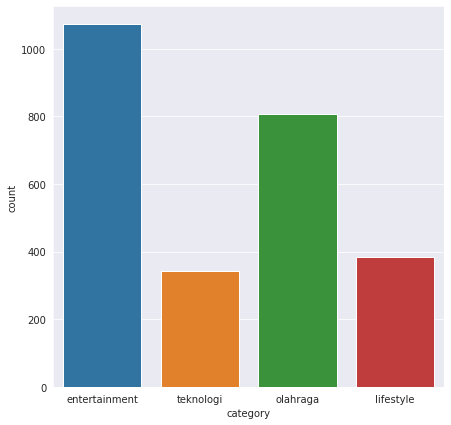

In [40]:
# Category Distribution (count)
print(df.category.value_counts())

# Category Distribution (plot)
fig = plt.figure(figsize=(7, 7))
plot = sns.countplot(x=df.category)

In [50]:
# Check sample title
print("Sample Title\n")
size = df.shape[0]
for i in range(10):
  idx = random.randint(1, size)
  sample = df.iloc[idx]
  print(f"{sample.category:15} -> {sample.title}")

Sample Title

entertainment   -> Lirik dan Chord September When It Comes - Roseanne & Johnny Cash
entertainment   -> Sinopsis Boys Over Flowers Episode 1, Lee Min Ho Menjadi Siswa Kaya Berkuasa
entertainment   -> Lirik dan Chord Lagu Waktu yang Menjawab - D'Masiv
olahraga        -> Chelsea Vs Man City, Guardiola Kehilangan 2 Palang Pintu Andalan
entertainment   -> Film Losmen Bu Broto Didedikasikan untuk Perempuan Indonesia
olahraga        -> 4 Aspek Pencak Silat
olahraga        -> Klasemen Liga Inggris Usai Man Utd dan Chelsea Kalah
entertainment   -> Chicco Jerikho Ungkap 2 Alasan Main di Film Aum!
lifestyle       -> Mengetahui Saat Jantung Berdebar Jadi Tanda Bahaya
entertainment   -> Hanung Bramantyo Kaget Dave Moffatt Sumbang 6 Lagu di Ulang Tahun Zaskia Adya Mecca


## Data Preprocessing

### Cleaning

In [75]:
import re

In [76]:
def cleaning_text(text):
    clean_str = text.lower() # lowercase
    clean_str = re.sub(r"(?:\@|#|https?\://)\S+", " ", clean_str) # eliminate username, url, hashtags
    clean_str = re.sub(r'&amp;', '', clean_str) # remove &amp; as it equals &
    clean_str = re.sub(r'[^\w\s]',' ', clean_str) # remove punctuation
    clean_str = re.sub('[\s\n\t\r]+', ' ', clean_str) # remove extra space
    clean_str = clean_str.strip() # trim
    # clean_str = " ".join([stemmer.stem(word) for word in clean_str.split()]) # stem
    # clean_str = remove_stopwords(clean_str) #remove stopwords and punctuation
    
    return clean_str

In [77]:
clean_title = df["title"].map(cleaning_text, na_action="ignore")
df.loc["clean_title"] = clean_title
df.head()

category  ...                                        clean_title
0  entertainment  ...                 lirik dan chord lagu say love jojo
1      teknologi  ...   10 media sosial yang jadi sumber berita warganet
2  entertainment  ...  10 lagu teratas di spotify indonesia lagu lali...
3      teknologi  ...  29 mobil diskon ppnbm diminta normal bertahap ...
4  entertainment  ...   2 sosok ini jadi inspirasi hidup deddy corbuzier

[5 rows x 3 columns]

### Tokenization

In [78]:
import string

In [79]:
# Create Stopword and Punctuation Set
stop = set() # set(stopwords)
punctuation = list(string.punctuation)
stop.update(punctuation)
print(len(stop))

32


In [ ]:
def remove_stopwords(text):
  final_text = []
  for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
  return " ".join(final_text)

### Stemming

In [74]:
!pip install PySastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [ ]:
#create stemmer
stem = StemmerFactory()
stemmer = stem.create_stemmer()

stemmer

In [1]:
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim

from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

     |████████████████████████████████| 210 kB 8.4 MB/s 


KeyboardInterrupt: ignored

## EDA

### Word Cloud for Lifestyle headlines

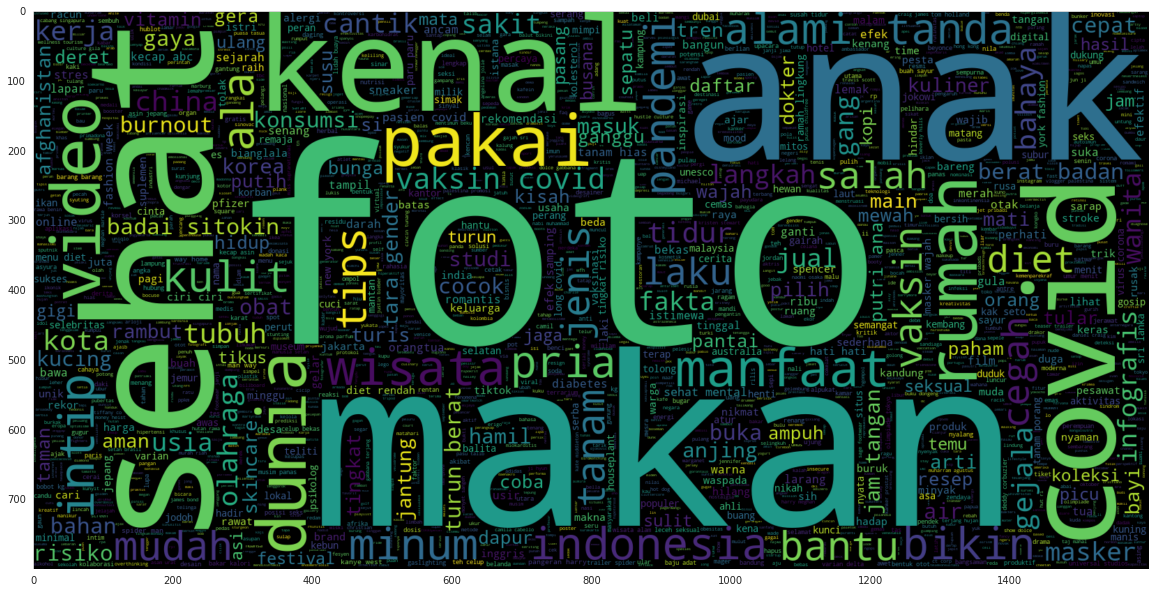

In [ ]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize = (20,20)) #
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(new_data[new_data.general_category == 'lifestyle'].clean_content))
plt.imshow(wc , interpolation = 'bilinear')

### Word Cloud for ENTERTAINMENT Headlines

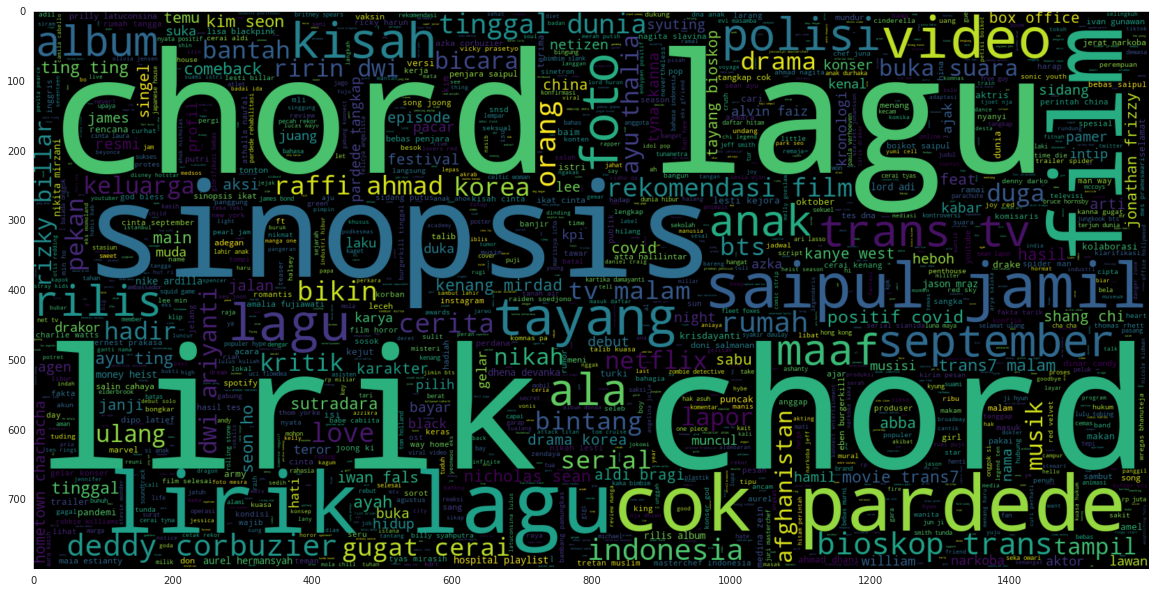

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(new_data[new_data.general_category == 'entertainment'].clean_content))
plt.imshow(wc , interpolation = 'bilinear')

### Word Cloud for Sport headlines

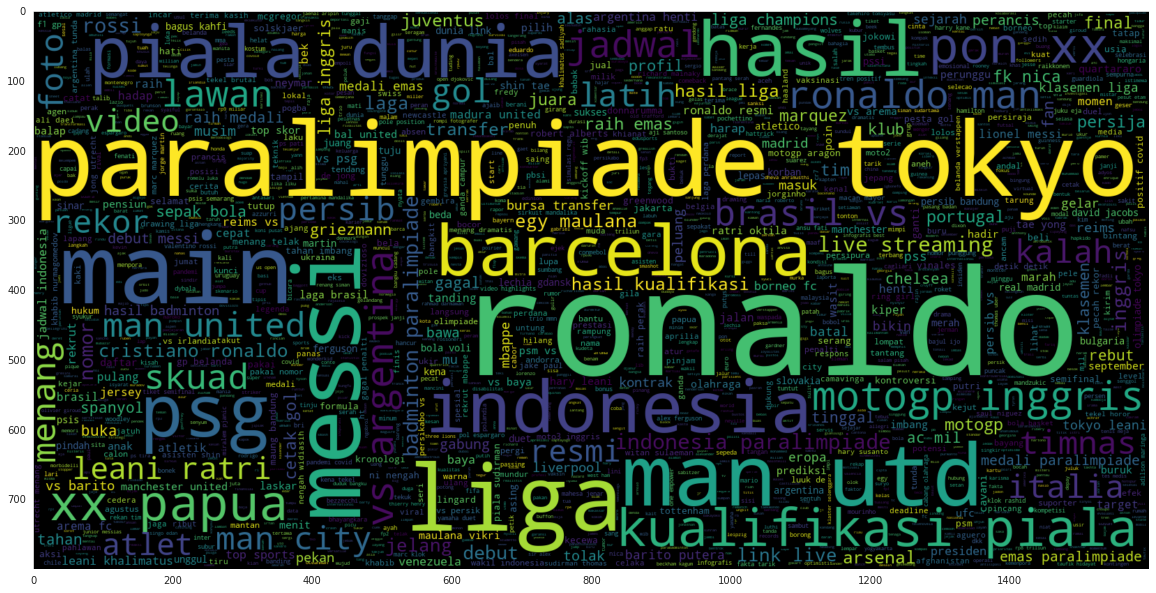

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(new_data[new_data.general_category == 'olahraga'].clean_content))
plt.imshow(wc , interpolation = 'bilinear')

### Word Cloud for Teknologi Headlines

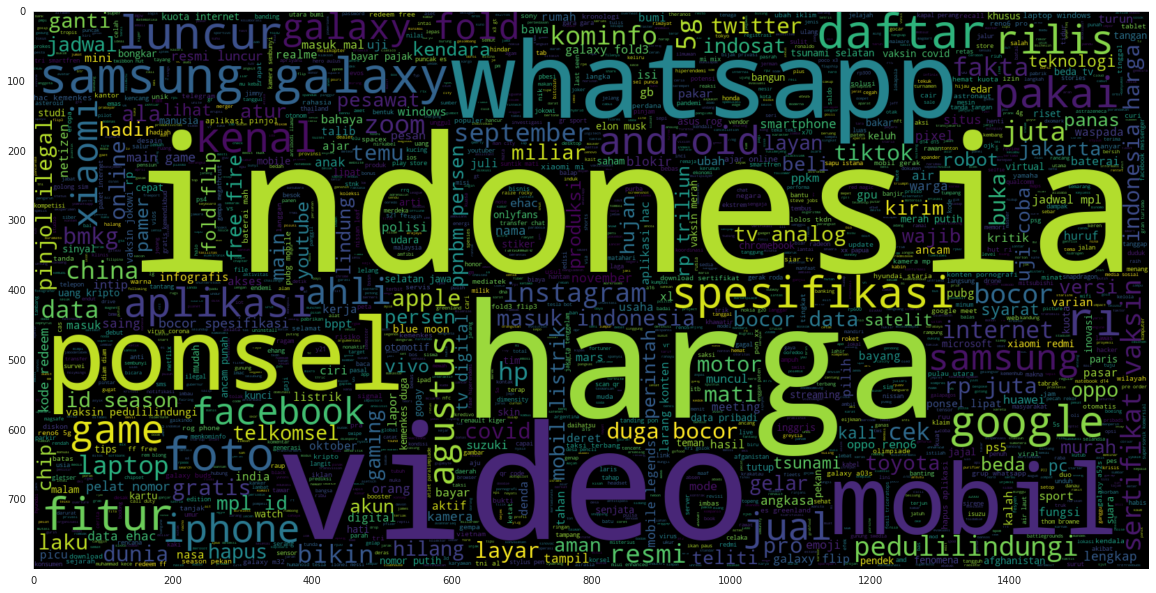

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(new_data[new_data.general_category == 'teknologi'].clean_content))
plt.imshow(wc , interpolation = 'bilinear')

### Plotting Number of Characters from each headlines category

Text(0.5, 1.0, 'Tech Headlines')

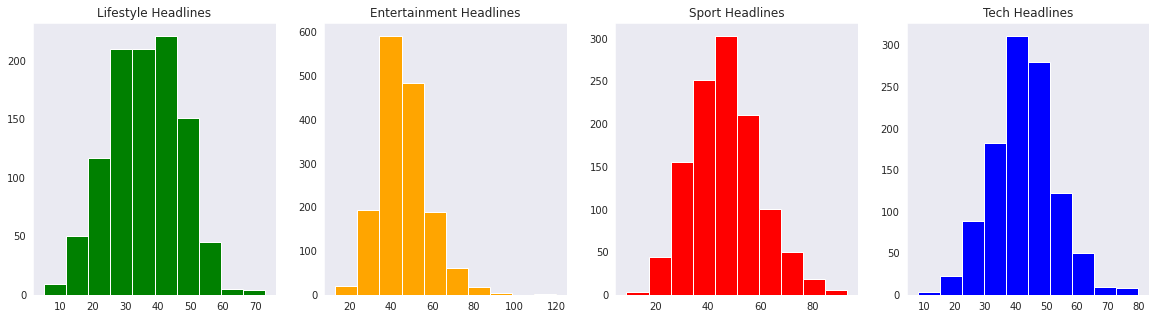

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,5))
# Lifestyle
text_len_life = new_data[new_data['general_category'] == 'lifestyle']['clean_content'].str.len()
ax1.hist(text_len_life,color='green')
ax1.set_title('Lifestyle Headlines')

# Entertainment
text_len_entertainment = new_data[new_data['general_category'] == 'entertainment']['clean_content'].str.len()
ax2.hist(text_len_entertainment,color='orange')
ax2.set_title('Entertainment Headlines')

# Sport
text_len_sport = new_data[new_data['general_category'] == 'olahraga']['clean_content'].str.len()
ax3.hist(text_len_sport,color='Red')
ax3.set_title('Sport Headlines')

# Technologies
text_len_tech = new_data[new_data['general_category'] == 'teknologi']['clean_content'].str.len()
ax4.hist(text_len_tech,color='Blue')
ax4.set_title('Tech Headlines')

In [ ]:
long_len = new_data[new_data['general_category'] == 'entertainment'].loc[new_data['clean_content'].str.len() > 100,:]
long_len['clean_content'].tolist()[1]

'populer hype leslar kaget buka amplop doni salmanan anggun anak pakai bahasa indonesia kembar mirna berat serial sianida'

In [ ]:
tes = 'populer hype leslar kaget buka amplop doni salmanan anggun anak pakai bahasa indonesia kembar mirna berat serial sianida'
len(tes)

120

### Plotting the number of Words for each Category Headlines

Text(0.5, 1.0, 'Tech Headlines')

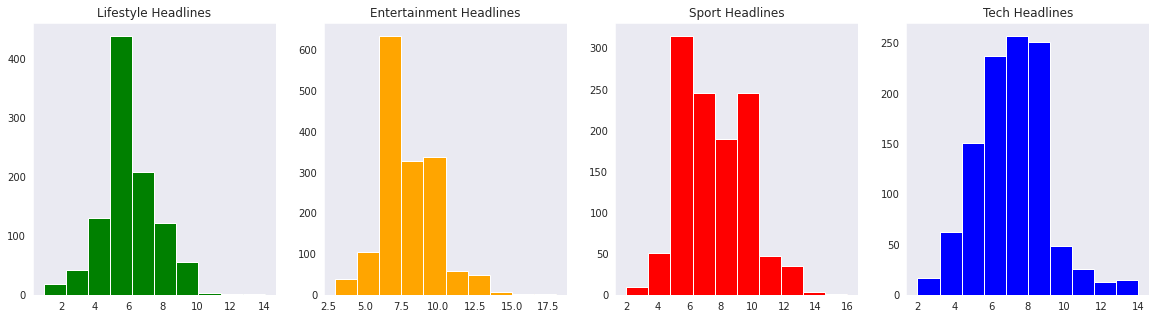

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,5))
# Lifestyle
text_len_life = new_data[new_data['general_category'] == 'lifestyle']['clean_content'].str.split().apply(lambda x: len(x))
ax1.hist(text_len_life,color='green')
ax1.set_title('Lifestyle Headlines')

# Entertainment
text_len_entertainment = new_data[new_data['general_category'] == 'entertainment']['clean_content'].str.split().apply(lambda x: len(x))
ax2.hist(text_len_entertainment,color='orange')
ax2.set_title('Entertainment Headlines')

# Sport
text_len_sport = new_data[new_data['general_category'] == 'olahraga']['clean_content'].str.split().apply(lambda x: len(x))
ax3.hist(text_len_sport,color='Red')
ax3.set_title('Sport Headlines')

# Technologies
text_len_tech = new_data[new_data['general_category'] == 'teknologi']['clean_content'].str.split().apply(lambda x: len(x))
ax4.hist(text_len_tech,color='Blue')
ax4.set_title('Tech Headlines')

## Converting text to format acceptable by gensim

Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.
What are word embeddings exactly? Loosely speaking, they are vector representations of a particular word. Having said this, what follows is how do we generate them? More importantly, how do they capture the context?
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

In [ ]:
words = []

for i in new_data.clean_content.values:
  words.append(i.split())

words[-1]

['4', 'provinsi', 'internet', 'seluler', 'kencang', 'indonesia']

In [ ]:
words

[['video', 'teliti', 'temu', 'batita', 'tular', 'covid', '19'],
 ['bahaya', 'lalilulelo', 'lupa', 'lot', 'pascacovid', '19'],
 ['5', 'utama', 'puasa', 'tasua', '9', 'muharram', '18', 'agustus', '2021'],
 ['niat',
  'puasa',
  'tasua',
  'asyura',
  '2021',
  '9',
  '10',
  'muharam',
  '1443',
  'h'],
 ['fine',
  'counsel',
  'sneaker',
  'lokal',
  'greysia',
  'polii',
  'jokowi',
  'effect'],
 ['intip', 'tumpeng', 'bentuk', 'kerucut'],
 ['intip', '9', 'bukti', 'indah', 'afghanistan'],
 ['5', 'bangun', 'tinggal', 'portugis', 'indonesia'],
 ['makna', 'pimpin', 'baju', 'adat', 'lampung', 'pakai', 'jokowi'],
 ['uyel', 'si', 'kerupuk', 'keriting', 'populer', 'lomba', '17', 'an'],
 ['foto', 'tepi', 'jenak', 'kota', 'tua', 'kastel', 'batavia'],
 ['kandung', 'masker', 'wajah', 'bagus', 'kulit', 'minyak'],
 ['sederhana', 'iriana', 'busana', 'serba', 'kuning', 'hut', 'ri', '76'],
 ['upacara',
  'hut',
  'ri',
  'ma',
  'ruf',
  'amin',
  'pakai',
  'baju',
  'adat',
  'sunda'],
 ['upacara', '

In [ ]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 150

#Creating Word Vectors by Word2Vec Method (
w2v_model = gensim.models.Word2Vec(sentences = words, size=EMBEDDING_DIM, window=15, min_count=1)
len(w2v_model.wv.vocab)

6943

In [ ]:
help(w2v_model)

Help on Word2Vec in module gensim.models.word2vec object:

class Word2Vec(gensim.models.base_any2vec.BaseWordEmbeddingsModel)
 |  Word2Vec(sentences=None, corpus_file=None, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, iter=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), max_final_vocab=None)
 |  
 |  Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/.
 |  
 |  Once you're finished training a model (=no more updates, only querying)
 |  store and use only the :class:`~gensim.models.keyedvectors.KeyedVectors` instance in `self.wv` to reduce memory.
 |  
 |  The model can be stored/loaded via its :meth:`~gensim.models.word2vec.Word2Vec.save` and
 |  :meth:`~gensim.models.word2vec.Word2Vec.load` methods.
 |  
 |  The trained word vectors can 

In [ ]:
len(w2v_model['ronaldo'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


150

### Tokenization

In [ ]:
import nltk

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
len(words)

4801

In [ ]:
maxlen = new_data.clean_content.map(lambda x: len(x)).max()

In [ ]:
maxlen

120

In [ ]:
tokenizer = text.Tokenizer(num_words=3000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = maxlen)
tokenizer

In [ ]:
tokenizer.word_index

{'lagu': 1,
 'lirik': 2,
 '2021': 3,
 'chord': 4,
 'indonesia': 5,
 '5': 6,
 'ronaldo': 7,
 '1': 8,
 'the': 9,
 'video': 10,
 '3': 11,
 'foto': 12,
 'sinopsis': 13,
 'vs': 14,
 'man': 15,
 'liga': 16,
 'dunia': 17,
 'paralimpiade': 18,
 'hasil': 19,
 'main': 20,
 'covid': 21,
 '7': 22,
 'anak': 23,
 'tokyo': 24,
 'film': 25,
 '19': 26,
 'messi': 27,
 '4': 28,
 'inggris': 29,
 'pakai': 30,
 'vaksin': 31,
 '2': 32,
 'kenal': 33,
 'harga': 34,
 'resmi': 35,
 'tv': 36,
 'bikin': 37,
 '6': 38,
 '10': 39,
 'alas': 40,
 'rumah': 41,
 'bocor': 42,
 'jadwal': 43,
 'rilis': 44,
 'utd': 45,
 'samsung': 46,
 'galaxy': 47,
 'mobil': 48,
 'daftar': 49,
 'buka': 50,
 'tinggal': 51,
 'september': 52,
 '2022': 53,
 'argentina': 54,
 'motogp': 55,
 'menang': 56,
 'masuk': 57,
 'makan': 58,
 'psg': 59,
 'raih': 60,
 'z': 61,
 'piala': 62,
 'united': 63,
 'whatsapp': 64,
 'luncur': 65,
 'china': 66,
 'sehat': 67,
 'malam': 68,
 'ponsel': 69,
 'ri': 70,
 'brasil': 71,
 'emas': 72,
 '8': 73,
 'rekor': 74,
 

In [ ]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1
vocab_size

6944

In [ ]:
tokenizer.word_index.items()

dict_items([('lagu', 1), ('lirik', 2), ('2021', 3), ('chord', 4), ('indonesia', 5), ('5', 6), ('ronaldo', 7), ('1', 8), ('the', 9), ('video', 10), ('3', 11), ('foto', 12), ('sinopsis', 13), ('vs', 14), ('man', 15), ('liga', 16), ('dunia', 17), ('paralimpiade', 18), ('hasil', 19), ('main', 20), ('covid', 21), ('7', 22), ('anak', 23), ('tokyo', 24), ('film', 25), ('19', 26), ('messi', 27), ('4', 28), ('inggris', 29), ('pakai', 30), ('vaksin', 31), ('2', 32), ('kenal', 33), ('harga', 34), ('resmi', 35), ('tv', 36), ('bikin', 37), ('6', 38), ('10', 39), ('alas', 40), ('rumah', 41), ('bocor', 42), ('jadwal', 43), ('rilis', 44), ('utd', 45), ('samsung', 46), ('galaxy', 47), ('mobil', 48), ('daftar', 49), ('buka', 50), ('tinggal', 51), ('september', 52), ('2022', 53), ('argentina', 54), ('motogp', 55), ('menang', 56), ('masuk', 57), ('makan', 58), ('psg', 59), ('raih', 60), ('z', 61), ('piala', 62), ('united', 63), ('whatsapp', 64), ('luncur', 65), ('china', 66), ('sehat', 67), ('malam', 68),

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [ ]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [ ]:
len(embedding_vectors[1])

150

## Training Word2vec Model

In [ ]:
from sklearn.preprocessing import OneHotEncoder

new_data['general_category'] = new_data['general_category'].astype('category')
new_data['general_category_code'] = new_data['general_category'].cat.codes


y = new_data[['general_category','general_category_code']]
oh = OneHotEncoder(handle_unknown='ignore')
y = pd.DataFrame(oh.fit_transform(y[['general_category_code']]).toarray())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
new_data[['general_category','general_category_code']].loc[new_data['general_category_code'] == 0,:]

general_category  general_category_code
513     entertainment                      0
514     entertainment                      0
515     entertainment                      0
516     entertainment                      0
517     entertainment                      0
...               ...                    ...
3757    entertainment                      0
3758    entertainment                      0
3759    entertainment                      0
3760    entertainment                      0
3761    entertainment                      0

[1561 rows x 2 columns]

### Defining model architecture using Bidirectional LSTM

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(4, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
x.shape

(4801, 120)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 150)           1041600   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 20, 256)           285696    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 1,383,236
Trainable params: 1,383,236
Non-trainable params: 0
_________________________________________________________________


### Splitting data and fitting the Model


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size = 0.2 , random_state = 0) 

In [ ]:
x_train.shape

(3840, 120)

In [ ]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 3)

Epoch 1/3
30/30 [==============================] - 133s 2s/step - loss: 0.3558 - acc: 0.6552 - val_loss: 0.1350 - val_acc: 0.9063
Epoch 2/3
30/30 [==============================] - 72s 2s/step - loss: 0.0945 - acc: 0.9380 - val_loss: 0.1223 - val_acc: 0.9240
Epoch 3/3
30/30 [==============================] - 72s 2s/step - loss: 0.0436 - acc: 0.9745 - val_loss: 0.1466 - val_acc: 0.9136


### Model Evaluation

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

120/120 [==============================] - 17s 134ms/step - loss: 0.0211 - acc: 0.9911
Accuracy of the model on Training Data is -  99.11458492279053
31/31 [==============================] - 4s 131ms/step - loss: 0.1466 - acc: 0.9136
Accuracy of the model on Testing Data is -  91.36316180229187


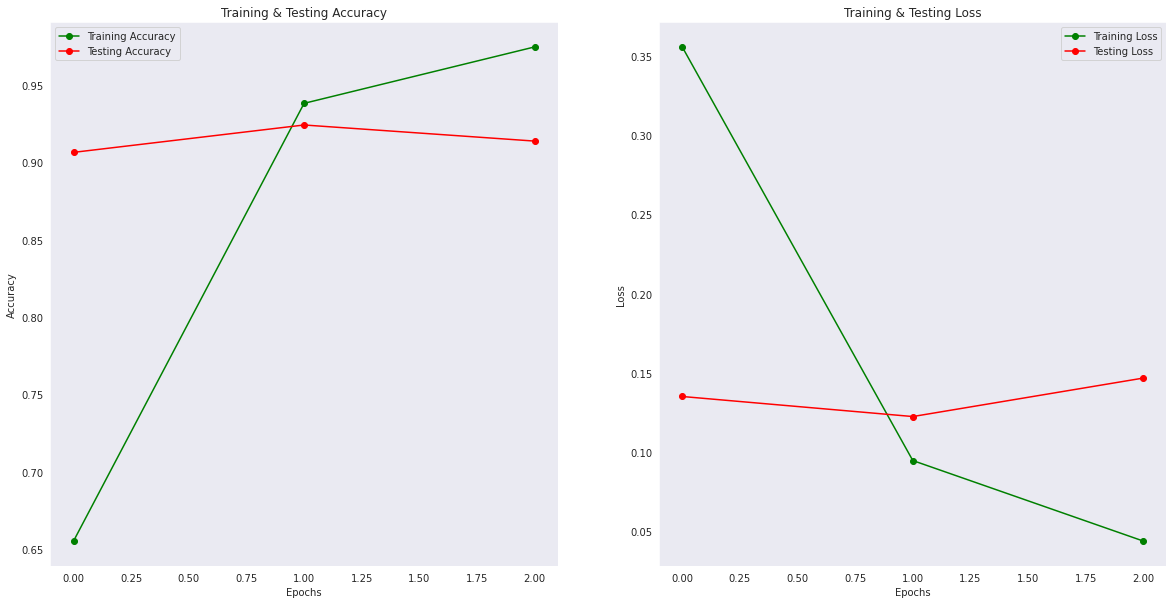

In [ ]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
result = model.predict(x_test)
print("Result:", result)
result = np.argmax(result,axis=1)
print(result)
new_y_test = np.argmax(y_test.values,axis=1)

result.shape
new_y_test.shape
CM = confusion_matrix(new_y_test, result)
# score = model.score(x_test, y_test)
print(CM)

Result: [[2.4198592e-03 2.5786161e-03 9.8874080e-01 1.0673702e-03]
 [9.9237442e-01 4.1247010e-03 8.5207820e-04 1.0919273e-03]
 [1.5538859e-01 8.6723667e-01 6.7701936e-04 1.6531050e-03]
 ...
 [4.9925625e-02 5.7198775e-01 7.0441158e-05 1.6373351e-01]
 [2.1099150e-03 8.3064735e-03 9.1269612e-04 9.8271668e-01]
 [1.2326837e-03 9.8125833e-01 4.1886568e-03 7.8040063e-03]]
[2 0 1 3 2 3 2 2 3 0 1 3 0 3 2 3 0 0 0 1 3 0 0 2 0 0 1 0 1 0 2 0 1 2 0 0 0
 2 0 0 1 2 0 2 3 0 0 0 0 3 0 2 0 3 0 0 2 1 1 3 1 3 1 0 0 0 0 1 2 3 2 0 1 3
 1 0 0 1 2 2 2 3 1 3 3 1 1 1 2 1 3 0 1 2 2 0 1 3 1 0 0 2 2 1 3 2 3 2 1 0 3
 1 1 0 3 0 3 0 1 1 1 3 0 1 0 3 2 2 2 1 3 2 0 1 1 0 0 3 1 0 1 3 0 0 0 0 1 3
 3 1 1 2 0 3 2 0 2 2 0 3 1 1 3 2 1 1 0 1 2 2 1 2 3 2 0 0 1 0 0 3 3 0 1 2 2
 0 2 0 2 2 0 0 0 1 3 3 1 0 1 2 1 0 2 3 3 1 3 0 0 1 3 1 1 3 1 0 0 2 3 1 1 0
 3 2 3 1 3 1 3 0 2 1 0 1 0 2 1 2 1 2 0 2 3 0 1 1 3 2 2 1 1 1 1 0 0 2 2 0 1
 3 3 0 2 3 2 0 0 3 1 0 2 1 2 0 3 2 0 0 2 2 0 2 3 0 2 2 3 0 3 1 1 2 2 2 1 0
 2 1 0 1 2 0 0 1 2 1 2 2 3 3 1 3

In [ ]:
# def train_classification(model, X_train, y_train, X_test, y_test):

#     result = model.predict(X_test)
#     result = np.argmax(result,axis=1)
#     print("Result:", result)

    
#     CM = confusion_matrix(y_test, result)
#     score = model.score(X_test, y_test)
#     print("Test Result:")
#     print("Confusion Matrix:")
#     print(CM)
#     print("Score:", score)
#     test = score
    
#     self_res = model.predict(X_train)
#     print("Self-Predict Result:", self_res)
    
#     CM = confusion_matrix(y_train, self_res)
#     score = model.score(X_train, y_train)
#     print("Self-Predict Test Result:")
#     print("Confusion Matrix:")
#     print(CM)
#     print("Score:", score)
#     self_test = score
    

<Figure size 432x288 with 0 Axes>

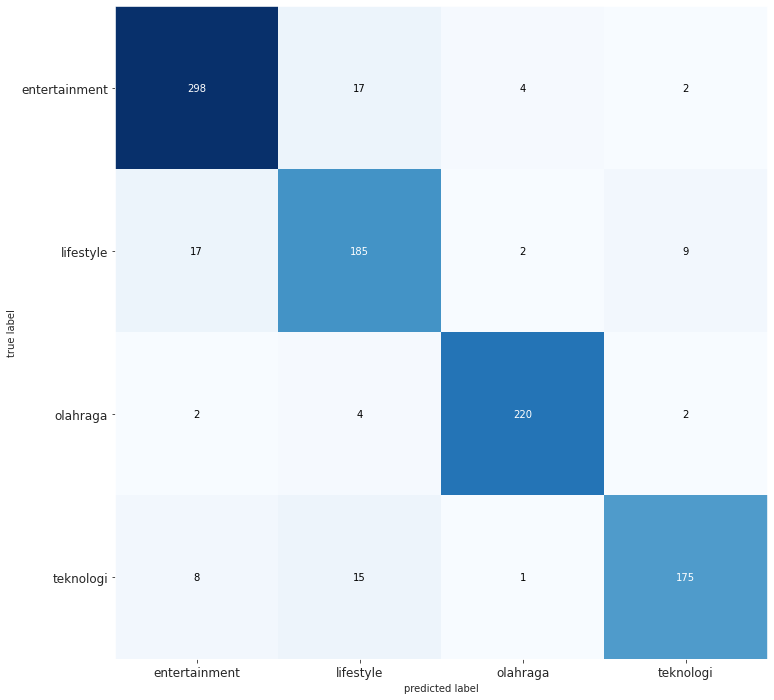

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

labels = ['entertainment','lifestyle','olahraga','teknologi']
preds = [np.argmax(i) for i in model.predict(x_test)]
cm  = confusion_matrix(new_y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

In [ ]:
print("Recall of the model is {:.2f}".format(recall_score(new_y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(new_y_test, preds, average='micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(new_y_test, preds)))

Recall of the model is 0.91
Precision of the model is 0.91
Accuracy of the model is 0.91


### Model Demo yoi

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from termcolor import colored

def modelDemo(news_text):

  #News Labels
  labels = ['entertainment','lifestyle','olahraga','teknologi']

  test_seq = pad_sequences(tokenizer.texts_to_sequences(news_text), maxlen=maxlen)

  test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

  for news, label in zip(news_text, test_preds):
      # print('{} - {}'.format(news, label))
      print('{} - {}'.format(colored(news, 'yellow'), colored(label, 'blue')))

In [ ]:
modelDemo(["Daftar Ponsel yang Dapat Android 12"])

Daftar Ponsel yang Dapat Android 12 - teknologi


In [ ]:
modelDemo(["Ceroboh Beri PIN Kartu Kredit, Ronaldo Kena Tipu Rp4,8 Miliar"])

Ceroboh Beri PIN Kartu Kredit, Ronaldo Kena Tipu Rp4,8 Miliar - olahraga


In [ ]:
modelDemo(['The Crown Menang Serial Drama Terbaik Emmy Awards 2021'])

The Crown Menang Serial Drama Terbaik Emmy Awards 2021 - entertainment


In [ ]:
modelDemo(['5 Makanan untuk Kurangi Efek Samping Vaksin Covid-19'])

5 Makanan untuk Kurangi Efek Samping Vaksin Covid-19 - lifestyle


In [ ]:
modelDemo(["7 Cara Alami Menurunkan Berat Badan"])

7 Cara Alami Menurunkan Berat Badan - lifestyle
